<a href="https://colab.research.google.com/github/liao771018/Team-Project/blob/main/%E6%A8%A1%E5%9E%8B%E8%A9%95%E4%BC%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# All Images

In [ ]:
# 圖片路徑資料夾
# img_dir = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片/test'
img_dir = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片/最終測試'

test_paths = glob(img_dir + '/*')
data_count = len(test_paths)

labels = ['bigfin squid',
      'neritic squid',
      'octopus',
      'squid',
      'cuttlefish']

cls2idx = { cls : i for i, cls in enumerate(labels)}

# 測試預測速度
n = 1000
test_run_time = []

print('測試資料筆數:', len(test_paths))

測試資料筆數: 215


In [ ]:
# 讀全部的圖片
x_ori, y_ori = [], []
for path in tqdm(test_paths):

    img = cv2.imread(path)[:,:,::-1]
    cls = path.split('/')[-1].split('_')[0]
    label = cls2idx[cls]
    x_ori.append(img)
    y_ori.append(label)

# 看一下 label 跟 count
unique_classes, counts = np.unique(y_ori, return_counts=True)
unique_classes, counts

  0%|          | 0/215 [00:00<?, ?it/s]

(array([0, 1, 2, 3, 4]), array([15, 96,  9, 11, 84]))

label: 1 
class: neritic squid 
shape: (453, 604, 3)


(<matplotlib.image.AxesImage at 0x7f501eee0950>, None)

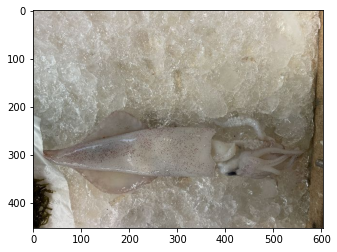

In [ ]:
# 隨機抽一張看看
idx = np.random.randint(0, len(test_paths))
plt.imshow(x_ori[idx]), print('label:', y_ori[idx], '\nclass:', labels[y_ori[idx]], '\nshape:', x_ori[idx].shape)

# 01_CNN

In [ ]:
IMG_SIZE = 224

# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0 # normalization
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/01_CNN/CNN_TP_1_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.34924541354179384


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y, pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y, pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

In [ ]:
'''
# 預測錯誤的 index
idx = np.nonzero(pre != y)[0]
x_o = np.array(x_ori)
# 預測錯誤的 圖 正確值 與 預測值
pre_false_img = x_o[idx]
pre_false_label = y[idx]
pre_false_pred = pre[idx]

# 設定圖的大小
plt.figure(figsize=(25,35))
width = 5
height = len(idx) // width + 1

idx2cls = {v: k for k, v in cls2idx.items()}

# 印出來看一下預測錯誤的圖
for i in range(len(idx)):

    plt.subplot(height, width, i+1)

    t = "[O]:{}\n[P]:{}".format(idx2cls[pre_false_label[i]], idx2cls[pre_false_pred[i]])
    plt.title(t)

    plt.axis("off")
    plt.imshow(pre_false_img[i].astype(int))
'''

'\n# 預測錯誤的 index\nidx = np.nonzero(pre != y)[0]\nx_o = np.array(x_ori)\n# 預測錯誤的 圖 正確值 與 預測值\npre_false_img = x_o[idx]\npre_false_label = y[idx]\npre_false_pred = pre[idx]\n\n# 設定圖的大小\nplt.figure(figsize=(25,35))\nwidth = 5\nheight = len(idx) // width + 1\n\nidx2cls = {v: k for k, v in cls2idx.items()}\n\n# 印出來看一下預測錯誤的圖\nfor i in range(len(idx)):\n\n    plt.subplot(height, width, i+1)\n\n    t = "[O]:{}\n[P]:{}".format(idx2cls[pre_false_label[i]], idx2cls[pre_false_pred[i]])\n    plt.title(t)\n\n    plt.axis("off")\n    plt.imshow(pre_false_img[i].astype(int))\n'

#02_ResNet50

In [ ]:
IMG_SIZE = 224

# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.resnet50.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/02_ResNet50/ResNet50_TP_1_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.23264641499519348


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y, pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y, pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#03_Inception_v3

In [ ]:
IMG_SIZE = 299

# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/03_Inception_v3/Inception_v3_TP_1_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.2758454065322876


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y, pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y, pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#04_Inception_Resnet_v2

In [ ]:
IMG_SIZE = 299

# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/04_Inception_Resnet_v2/Inception_Resnet_v2_TP_0_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.5732205708026886


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y, pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y, pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#05_ResNet152_v2

In [ ]:
IMG_SIZE = 224

# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/05_ResNet152_v2/ResNet152_v2_TP_1_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.5124452090263367


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y, pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y, pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#06_EfficentNetV2S

In [ ]:
IMG_SIZE = 224

from tensorflow.keras.utils import to_categorical
# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, len(labels)))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/06_1_EfficientNetV2S/EfficientNetV2S_TP_1_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.23982524061203003


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y.argmax(axis=-1), pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y.argmax(axis=-1), pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#07_VGG16

In [ ]:
IMG_SIZE = 224

# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.vgg16.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/07_VGG16/VGG16_j.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.5348863451480865


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y, pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y, pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#08_EfficientNetV2M

In [ ]:
IMG_SIZE = 224

from tensorflow.keras.utils import to_categorical
# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, len(labels)))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    y_cat = to_categorical(y_ori[i], num_classes=len(labels))
        
    x[i] = img
    y[i] = y_cat

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/08_EfficientNetV2M-OneHot/model.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.3713720066547394


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y.argmax(axis=-1), pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y.argmax(axis=-1), pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#09_EfficientNetB4


In [ ]:
IMG_SIZE = 224

from tensorflow.keras.utils import to_categorical
# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count,))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
            
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/215 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/09_EfficientNetB4/EfficientNetB4_TP_3_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.2280680055618286


In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/09_EfficientNetB4/EfficientNetB4_TP_3_best.h5'
model = load_model(model_path)

# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y.argmax(axis=-1), pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])


,bigfin squid預測,neritic squid預測,octopus預測,squid預測,cuttlefish預測
bigfin squid真實,9,3,1,0,2
neritic squid真實,9,69,1,11,6
octopus真實,0,0,8,0,1
squid真實,0,3,0,7,1
cuttlefish真實,4,1,7,1,71


In [ ]:
x.shape, y.shape
model.evaluate(x, y)

7/7 [==============================] - 32s 4s/step - loss: 0.8140 - accuracy: 0.7628


[0.8140150904655457, 0.7627906799316406]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


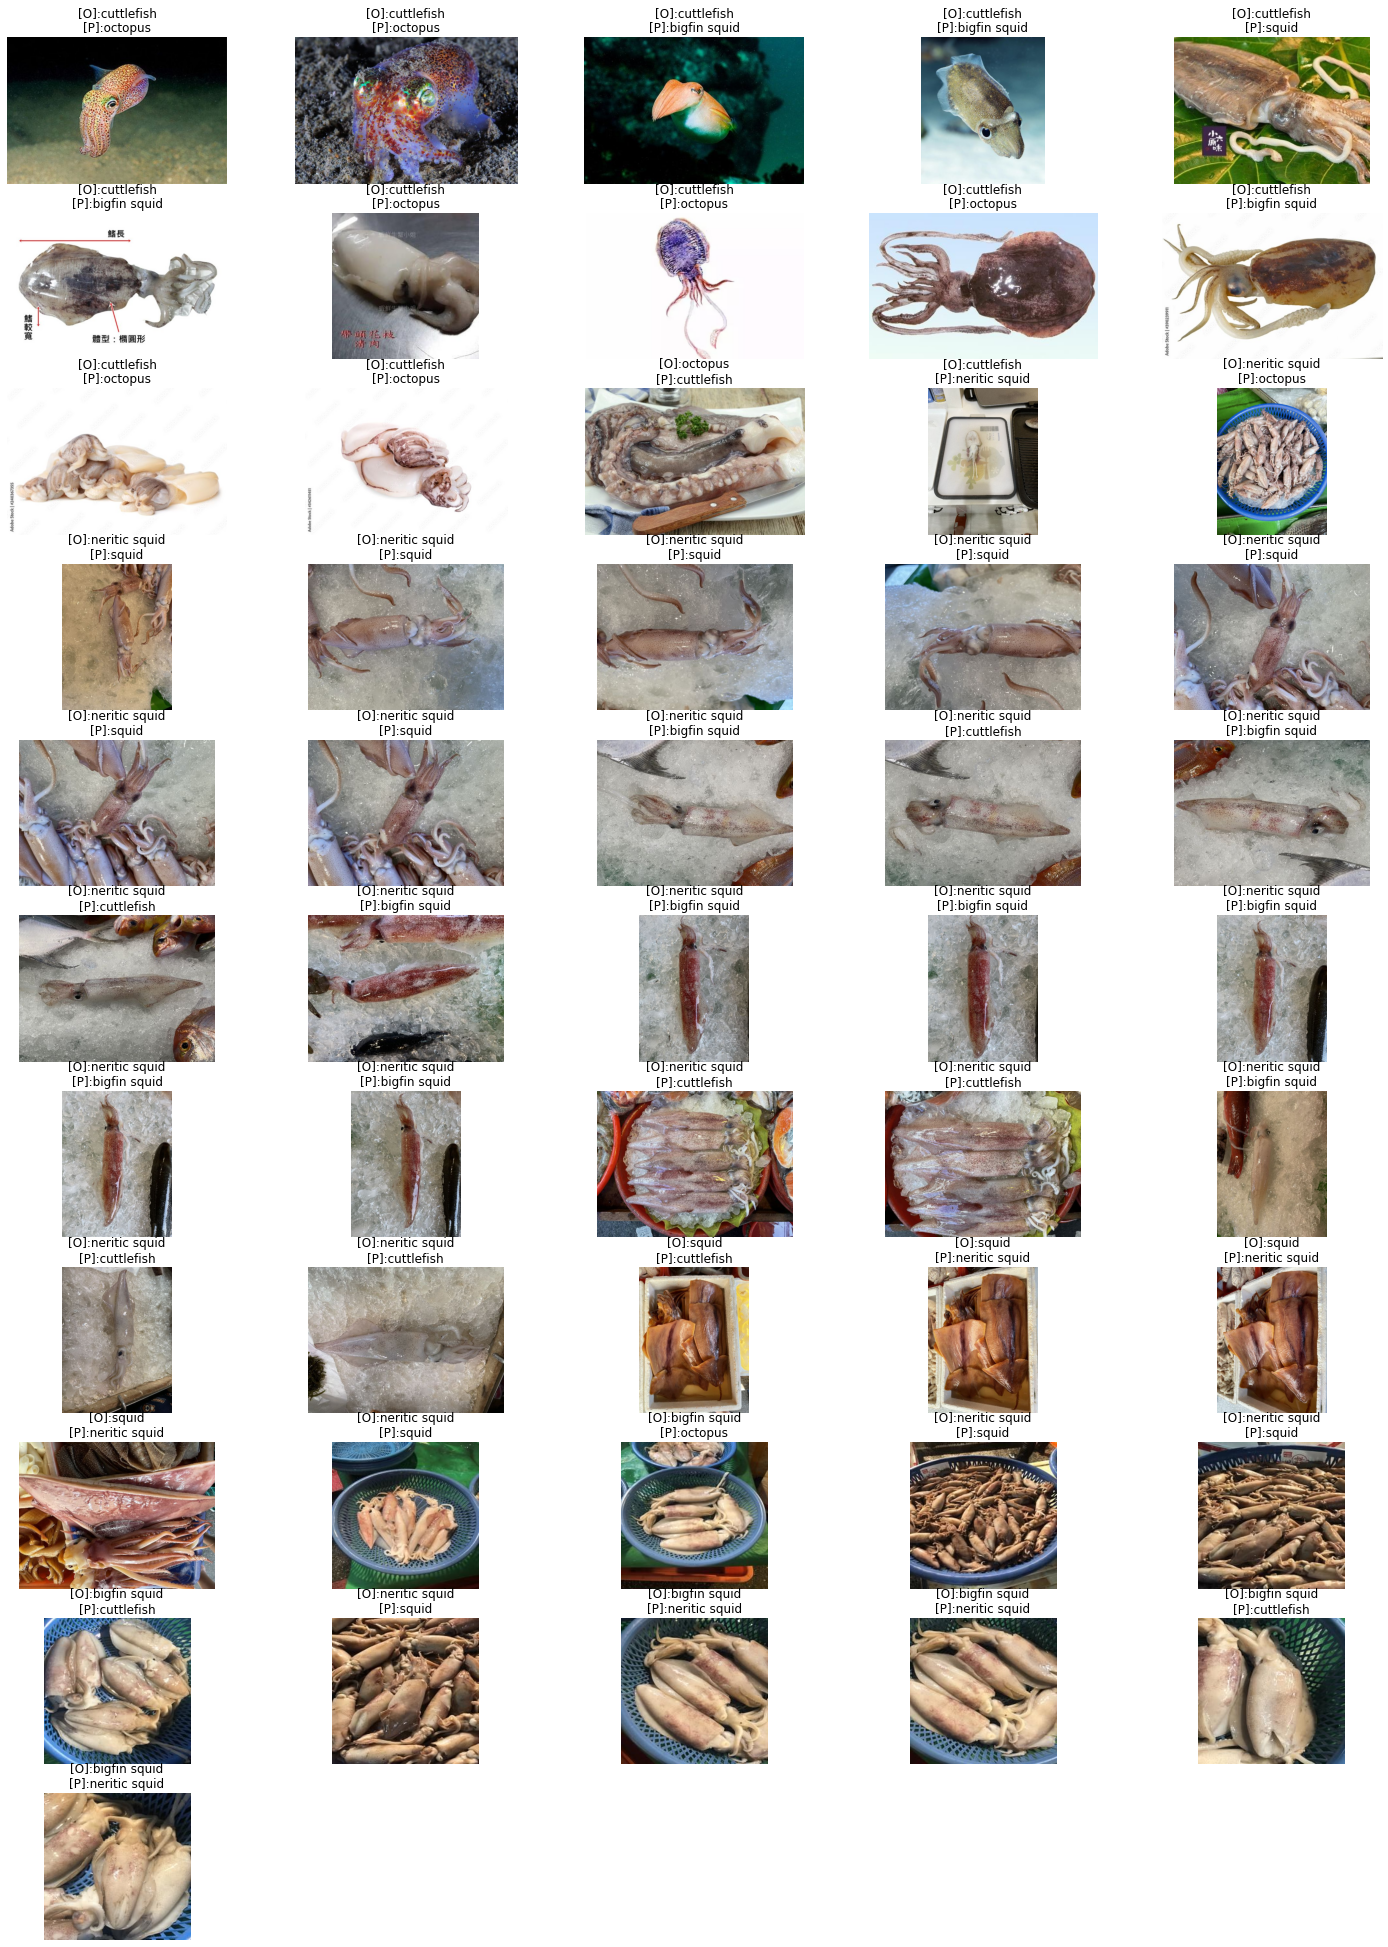

In [ ]:
# 預測錯誤的 index
idx = np.nonzero(pre != y)[0]
x_o = np.array(x_ori)
# 預測錯誤的 圖 正確值 與 預測值
pre_false_img = x_o[idx]
pre_false_label = y[idx]
pre_false_pred = pre[idx]

# 設定圖的大小
plt.figure(figsize=(25,35))
width = 5
height = len(idx) // width + 1

idx2cls = {v: k for k, v in cls2idx.items()}

# 印出來看一下預測錯誤的圖
for i in range(len(idx)):

    plt.subplot(height, width, i+1)

    t = "[O]:{}\n[P]:{}".format(idx2cls[pre_false_label[i]], idx2cls[pre_false_pred[i]])
    plt.title(t)

    plt.axis("off")
    plt.imshow(pre_false_img[i].astype(int))

#10_EfficientNetB7

In [ ]:
IMG_SIZE = 224

from tensorflow.keras.utils import to_categorical
# 做一個全為 0 的 np.array 來放 preprocess 後的資料
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

for i, x_img in enumerate(tqdm(x_ori)):

    img = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
        
    x[i] = img
    y[i] = y_ori[i]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/10_EfficientNetB7/EfficientNetB7_TP_1_best.h5'
model = load_model(model_path)

# 計算模型預測平均速度
total_time = 0
for i in tqdm(range(n)):

    idx = np.random.randint(0, len(test_paths))

    start = time.time()
    model.predict(x[idx].reshape(1, IMG_SIZE, IMG_SIZE, 3))
    end = time.time()
    
    total_time += (end - start)

avg_time = total_time / n

test_run_time.append(avg_time)
print('run_time:', avg_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

run_time: 0.4821301794052124


In [ ]:
'''
# 混淆矩陣

pre = model.predict(x).argmax(axis=-1)
mat = confusion_matrix(y.argmax(axis=-1), pre)

pd.DataFrame(mat,
       columns=['{}預測'.format(i) for i in cls2idx],
       index=['{}真實'.format(i) for i in cls2idx])
'''

"\n# 混淆矩陣\n\npre = model.predict(x).argmax(axis=-1)\nmat = confusion_matrix(y.argmax(axis=-1), pre)\n\npd.DataFrame(mat,\n       columns=['{}預測'.format(i) for i in cls2idx],\n       index=['{}真實'.format(i) for i in cls2idx])\n"

#綜合

In [ ]:
df = pd.DataFrame(
          {"avg_time" : test_run_time},
          index=[
              "01_CNN", 
              "02_ResNet50", 
              "03_Inception_v3", 
              "04_Inception_Resnet_v2", 
              "05_ResNet152_v2", 
              "06_EfficientNetV2S", 
              "07_VGG16", 
              "08_EfficientNetV2M",
              "09_EfficientNetB4",
              "10_EfficientNetB7"
          ]
)

df

,avg_time
01_CNN,0.349245
02_ResNet50,0.232646
03_Inception_v3,0.275845
04_Inception_Resnet_v2,0.573221
05_ResNet152_v2,0.512445
06_EfficientNetV2S,0.239825
07_VGG16,0.534886
08_EfficientNetV2M,0.371372
09_EfficientNetB4,0.228068
10_EfficientNetB7,0.482130
